In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ronan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ronan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ronan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Ronan\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [4]:
%%capture
!pip install contractions
import contractions

In [5]:
plt.style.use('seaborn-pastel')

+ Visão geral do DataFrame

In [6]:
df = pd.read_csv('Tweets.csv', usecols=['airline_sentiment', 'text'])
df.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


+ Verificando a distribuição dos dados.

In [7]:
df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<AxesSubplot:>

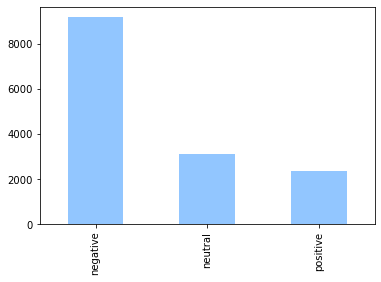

In [8]:
df.airline_sentiment.value_counts().plot(kind='bar')

+ Os dados estão desbalanceados. Requerendo um processo de oversampling e/ou undersampling.
+ Primeiramente, aplicaremos um processo de transformação dos dados.
  - A classe com valor `negative` receberá o valor -1;
  - A classe `neutral` receberá o valor 0; e
  - A classe `positive` receberá o valor 1.

In [9]:
condlist = [
  df.airline_sentiment == 'negative',
  df.airline_sentiment == 'neutral',
  df.airline_sentiment == 'positive'
]

choicelist = [-1, 0, 1]

df.airline_sentiment = np.select(condlist, choicelist, default=2)

In [10]:
neg, neu, pos = df.airline_sentiment.value_counts()
print('neg:', neg)
print('neu:', neu)
print('pos:', pos)

neg: 9178
neu: 3099
pos: 2363


In [11]:
# Separação do DataFrame em classes distintas
df_negative = df[df['airline_sentiment'] == -1]
df_neutral  = df[df['airline_sentiment'] ==  0]
df_positive = df[df['airline_sentiment'] ==  1]

# Undersampling nas classes negatives e positivas
df_negative_under = df_negative.sample(pos)
df_neutral_under  = df_neutral.sample(pos)

# Junção dos 3 DataFrames em um único
df_under = pd.concat([df_negative_under, df_neutral_under, df_positive],
                     axis=0)

<AxesSubplot:>

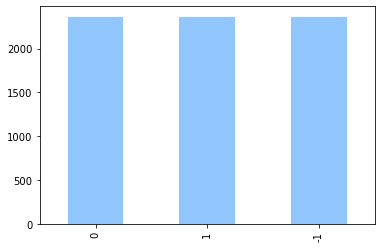

In [12]:
df_under.airline_sentiment.value_counts().plot(kind='bar')

In [13]:
df_under.reset_index(drop=True, inplace=True)

In [14]:
# Remoção das entradas duplicadas
df_under.drop_duplicates(['text'], inplace=True)
df = df_under
df.shape

(6984, 2)

# Pré-Processamento dos Dados:

In [15]:
# Definição das funções de limpeza de strings

def format_string(text):
  text = text.lower()
  # Remoção de links
  formated_text = re.sub(r'http\S+', '', text)
  # Remoção das mentions (eg. @fulanodetal)
  formated_text = re.sub(r'@[\w]* ', '', formated_text)
  # Remoção das contrações (eg. I'm --> I am)
  formated_text = contractions.fix(formated_text)
  # Simplificação do texto
  formated_text = re.sub(r'[^a-zA-Z0-9@# ]', '', formated_text)
  return (''.join(formated_text)).strip()

def remove_stopwords(text, tokenizer):
  words = tokenizer.tokenize(text)
  newwords = [word for word in words if word not in stopwords.words('english')]
  return (' '.join(newwords)).strip()

def lemmatize_string(text, lemmatizer):
  final_text = ''
  for word in text.split(' '):
    final_text += lemmatizer.lemmatize(word) + ' '
  return final_text

def stemming_string(text, stemmer):
  final_text = ''
  for word in text.split(' '):
    final_text += stemmer.stem(word) + ' '
  return final_text

In [16]:
# Instanciação das classes exigidas
tweet_tokenizer = TweetTokenizer()

string_lemmatizer = WordNetLemmatizer()

string_stemmer = SnowballStemmer('english')

In [17]:
classes, tweets = df['airline_sentiment'], df['text']

+ Aplicando formatação nos comentários

In [18]:
tweets = tweets.map(format_string)

+ Removendo as stopword dos comentários

In [19]:
tweets = tweets.map(lambda txt: remove_stopwords(txt, tweet_tokenizer))

+ Stemming

In [20]:
tweets = tweets.map(lambda txt: stemming_string(txt, string_stemmer))

+ Lemmatization

In [21]:
tweets = tweets.map(lambda txt: lemmatize_string(txt, string_lemmatizer))

In [22]:
tweets.drop_duplicates(inplace=True)

# Aplicação dos algoritmos

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.linear_model import PassiveAggressiveClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import Perceptron

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [24]:
processed_df = pd.concat([tweets, classes], axis=1)
processed_df.dropna(how='any', inplace=True)

In [25]:
# Visão geral do DataFrame
processed_df

,text,airline_sentiment
0,i go write post experi custom servic tank #jet...,-1
1,everi citi nationwid sale fabul fare noth buff...,-1
2,lost bag flight chi eri land 15 hr agoyet stil...,-1
3,peopl status get buy upgd much le cost ahead p...,-1
4,flt 1249 cancel flightl get email @330 happen ...,-1
...,...,...
7083,love compani staff amaz made uncomfort situat ...,1
7084,love new plane jfklax run mayb one day one ame...,1
7085,flight 236 great fantast cabin crew land #than...,1
7086,thank @americanair custom relat review concern...,1


In [26]:
vectorizer = CountVectorizer(analyzer="word", tokenizer=tweet_tokenizer.tokenize)

+ Dados vetorizados

In [27]:
freq_tweets = vectorizer.fit_transform(processed_df['text'])
freq_tweets.shape

(6711, 7973)

+ Separação em conjunto de treinamento e teste

In [30]:
X_train, X_test, y_train, y_test = \
  train_test_split(freq_tweets,
                   processed_df['airline_sentiment'],
                   test_size=0.33, 
                   random_state=42)
y_train

2083   -1
6314    1
3439    0
5876    1
1799   -1
       ..
3863    0
5388    1
5426    1
5602    1
863    -1
Name: airline_sentiment, Length: 4496, dtype: int32

+ Testando múltiplos algoritmos

In [28]:
#BA = Basic Algorithms
classificadores_BA = {
    'Linear SVC': LinearSVC(random_state=0, tol=1e-5),
    'Logistic Regression':LogisticRegression(random_state=0, max_iter=1000),
    'Multi-Layered Perceptron':MLPClassifier(random_state=1, max_iter=300),
    'KNN':KNeighborsClassifier(n_neighbors=3)
}

cls_stats_BA = {}

for model in classificadores_BA:
    cls_stats_BA[model] = 0.0

for model, cls in classificadores_BA.items():
        cls.fit(X_train, y_train)
        cls_stats_BA[model] = cls.score(X_test, y_test)
        print(f'{model} done')

# Resultado do modelos -- acurácia bruta
print(f'{"model":<32} | {"accuracy":<15}\n{"-"*30}')
for model in cls_stats_BA:
  accuracy = cls_stats_BA[model]
  print(f'{model:<32} | {accuracy:<1.5f}')
    
cls_stats_BA_save = cls_stats_BA

Linear SVC done
Logistic Regression done
Multi-Layered Perceptron done
KNN done
model                            | accuracy       
------------------------------
Linear SVC                       | 0.67872
Logistic Regression              | 0.70312
Multi-Layered Perceptron         | 0.63037
KNN                              | 0.48441


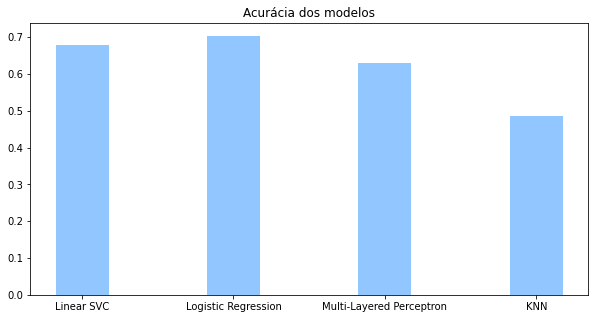

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
y_values = list(cls_stats_BA.values())
# ymin = min(y_values) * .997
# ymax = max(y_values) * 1.002
ax.bar(list(cls_stats_BA.keys()), y_values, width=0.35)
# ax.set_ylim(ymin, ymax)
ax.set_title('Acurácia dos modelos')
plt.show()

+ Teste do modelo

In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = np.logspace(-4, 4, 20)
max_iter = [1000, 1500, 2000]
tol = [0.0001, 0.001, 0.01]

grid = dict(solver=solvers,
            penalty=penalty,
            C=c_values,
            max_iter=max_iter,
            tol=tol)

LR = LogisticRegression(random_state=0, n_jobs=-1)

clf = GridSearchCV(LR, grid, scoring='accuracy', n_jobs=-1)

In [32]:
clf.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


GridSearchCV(estimator=LogisticRegression(n_jobs=-1, random_state=0), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [1000, 1500, 2000], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='accuracy')

In [33]:
clf.best_estimator_

LogisticRegression(C=0.615848211066026, max_iter=1000, n_jobs=-1,
                   random_state=0, solver='liblinear', tol=0.01)

In [34]:
print(f'LR acurácia: {clf.best_score_}')

LR acurácia: 0.7088804437496747


+ Treinamento do modelo por cross-validation

In [35]:
from sklearn.model_selection import cross_validate

In [36]:
classificadores_BA = {
    'Linear SVC': LinearSVC(random_state=0, tol=1e-5),
    'Logistic Regression':LogisticRegression(random_state=0, max_iter=1000),
    'Multi-Layered Perceptron':MLPClassifier(random_state=1, max_iter=300),
    'KNN':KNeighborsClassifier(n_neighbors=3)
}

cv_result_BA = {}

for model in classificadores_BA:
  cv_result_BA[model] = []

for model in classificadores_BA:
  cv_result_BA[model] = cross_validate(classificadores_BA[model],
                                    X=freq_tweets,
                                    y=processed_df['airline_sentiment'],
                                    cv=10,
                                    scoring='accuracy',
                                    return_estimator=True)

+ Valores de acurácia dos modelos via Cross Validation

In [37]:
accuracy_values_BA = []
fit_time_values_BA = []
score_time_values_BA = []

for cls in cv_result_BA:
  accuracy_values_BA.append(cv_result_BA[cls]["test_score"])
  score_time_values_BA.append(cv_result_BA[cls]["score_time"])
  fit_time_values_BA.append(cv_result_BA[cls]["fit_time"])

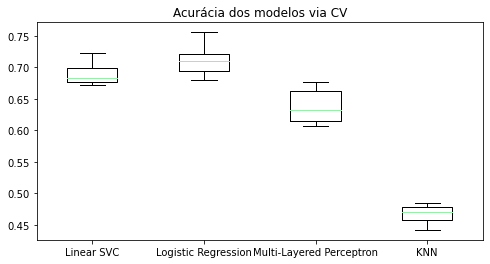

acurácia média nos testes:

Linear SVC                  0.690126
Logistic Regression         0.713092
Multi-Layered Perceptron    0.636585
KNN                         0.467345
dtype: float64


In [38]:
fig, ax = plt.subplots(figsize=(8,4))
ax.boxplot(accuracy_values_BA)
ax.set_xticklabels(cv_result_BA.keys())
ax.set_title('Acurácia dos modelos via CV')
plt.show()

meanAcurracy = pd.DataFrame\
            (list(zip(accuracy_values_BA[0],accuracy_values_BA[1],accuracy_values_BA[2],accuracy_values_BA[3])),\
            columns = ['Linear SVC','Logistic Regression','Multi-Layered Perceptron','KNN'])
print(f'acurácia média nos testes:\n\n{meanAcurracy.mean()}')

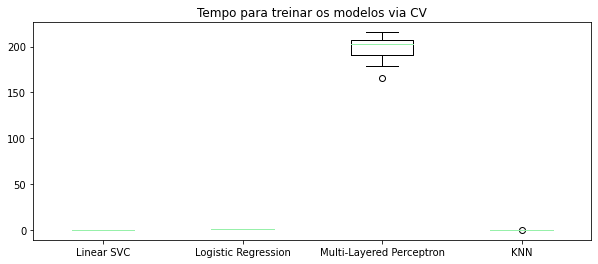

tempo médio de treino:

Linear SVC                    0.252818
Logistic Regression           0.583344
Multi-Layered Perceptron    197.632426
KNN                           0.002101
dtype: float64


In [39]:
fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(fit_time_values_BA)
ax.set_xticklabels(cv_result_BA.keys())
ax.set_title('Tempo para treinar os modelos via CV')
plt.show()
meanTimeTrain = pd.DataFrame\
            (list(zip(fit_time_values_BA[0],fit_time_values_BA[1],fit_time_values_BA[2],fit_time_values_BA[3])),\
            columns = ['Linear SVC','Logistic Regression','Multi-Layered Perceptron','KNN'])
print(f'tempo médio de treino:\n\n{meanTimeTrain.mean()}')

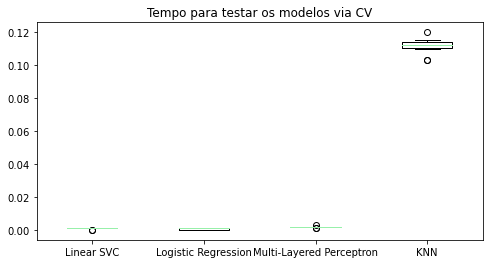

tempo médio de teste:

Linear SVC                  0.000800
Logistic Regression         0.000700
Multi-Layered Perceptron    0.001900
KNN                         0.111408
dtype: float64


In [40]:
fig, ax = plt.subplots(figsize=(8,4))
ax.boxplot(score_time_values_BA)
ax.set_xticklabels(cv_result_BA.keys())
ax.set_title('Tempo para testar os modelos via CV')
plt.show()


meanTimeTest = pd.DataFrame\
            (list(zip(score_time_values_BA[0],score_time_values_BA[1],score_time_values_BA[2],score_time_values_BA[3])),\
            columns = ['Linear SVC','Logistic Regression','Multi-Layered Perceptron','KNN'])
print(f'tempo médio de teste:\n\n{meanTimeTest.mean()}')

In [41]:
# Resultado do modelos -- acurácia no cross validation
actual = 0
print(f'{"model":<32} | {"accuracy":<15}\n{"-"*43}')
for cls in cv_result_BA:
  accuracy = cv_result_BA[cls]["test_score"].mean()
  print(f'{cls:<32} | {accuracy:<1.5f}')
  if (actual < accuracy) :
    cv_result_BA_best_estimator = cv_result_BA[cls]['estimator'][0]

model                            | accuracy       
-------------------------------------------
Linear SVC                       | 0.69013
Logistic Regression              | 0.71309
Multi-Layered Perceptron         | 0.63659
KNN                              | 0.46734


+ Matriz de confusão para modelo treinado em Holdout

In [42]:
from sklearn.metrics import plot_confusion_matrix

In [43]:
#print(cv_result_BA)
for cls in cv_result_BA:
    print(cv_result_BA[cls]['estimator'][0])

LinearSVC(random_state=0, tol=1e-05)
LogisticRegression(max_iter=1000, random_state=0)
MLPClassifier(max_iter=300, random_state=1)
KNeighborsClassifier(n_neighbors=3)


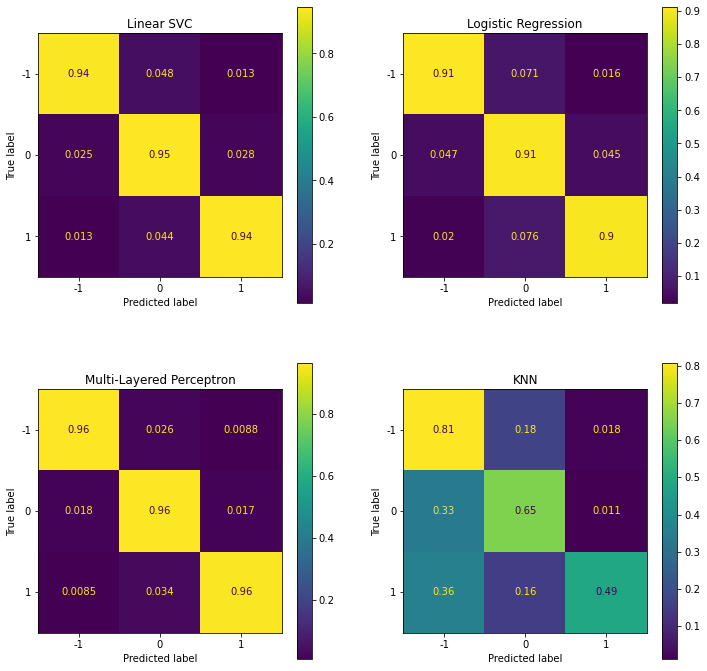

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, clf in enumerate(cv_result_BA):
  x = i//2
  y = i%2
  axs[x, y].set_title(clf)
  cv_model = cv_result_BA[clf]['estimator'][0]
  plot_confusion_matrix(cv_model, X_test, y_test, normalize='true', ax=axs[x, y])

plt.show() 

+ Aplicando alguns algoritmos avançados

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [54]:
#AA = Advanced Algorithm
classificadores_AA = {
    'Random Forest': RandomForestClassifier(max_depth=2, random_state=0),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=0),
    'XGBoost': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0),
}

cls_stats_AA = {}

for model in classificadores_AA:
    cls_stats_AA[model] = 0.0

for model, cls in classificadores_AA.items():
        cls.fit(X_train, y_train)
        cls_stats_AA[model] = cls.score(X_test, y_test)
        #print(f'{model} done')

# Resultado do modelos - acurácia bruta
print(f'{"model":<32} | {"accuracy":<15}\n{"-"*30}')
for model in cls_stats_AA:
  accuracy = cls_stats_AA[model]
  print(f'{model:<32} | {accuracy:<1.5f}')
        

model                            | accuracy       
------------------------------
Random Forest                    | 0.53909
AdaBoost                         | 0.67375
XGBoost                          | 0.68233


In [55]:
clsvalues = []
for model in cls_stats_BA_save:
    aux = cls_stats_BA_save[model]
    clsvalues.append(aux)
for model in cls_stats_AA:
    aux = cls_stats_AA[model]
    clsvalues.append(aux)
aux1 = list(cls_stats_BA_save.keys())
aux2 = list(cls_stats_AA.keys())
df = pd.Series((v for v in aux1))
df2 = pd.Series((v for v in aux2), index=[4, 5, 6])
df = df.append(df2)

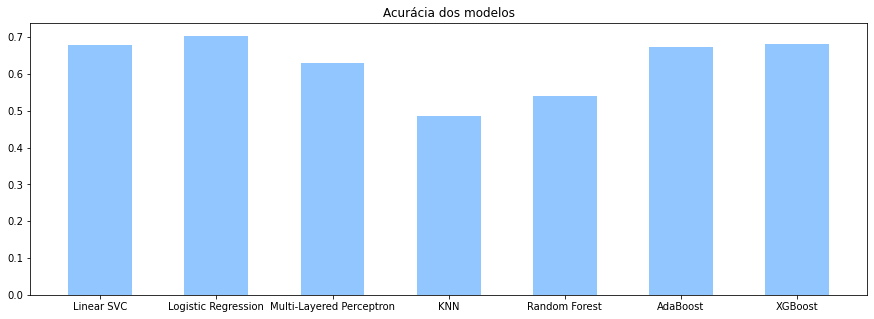

Linear SVC 0.6787
Logistic Regression 0.7031
Multi-Layered Perceptron 0.6304
KNN 0.4844
Random Forest 0.5391
AdaBoost 0.6737
XGBoost 0.6823


In [56]:
fig, ax = plt.subplots(figsize=(15, 5))
y_values = clsvalues
ax.bar(df, y_values, width=0.55)
ax.set_title('Acurácia dos modelos')
plt.show()
i = 0
for model in df:
    print(model,f'{clsvalues[i]:.4f}')
    i+=1

In [57]:
classificadores_AA = {
    'Random Forest': RandomForestClassifier(max_depth=2, random_state=0),
    'AdaBoost':AdaBoostClassifier(n_estimators=100, random_state=0),
    'XGBoost': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0),
}

cv_result_AA = {}

for model in classificadores_AA:
  cv_result_AA[model] = []

for model in classificadores_AA:
  cv_result_AA[model] = cross_validate(classificadores_AA[model],
                                    X=freq_tweets,
                                    y=processed_df['airline_sentiment'],
                                    cv=10,
                                    scoring='accuracy',
                                    return_estimator=True)

In [58]:
accuracy_values_AA = []
fit_time_values_AA = []
score_time_values_AA = []

for cls in cv_result_AA:
  accuracy_values_AA.append(cv_result_AA[cls]["test_score"])
  score_time_values_AA.append(cv_result_AA[cls]["score_time"])
  fit_time_values_AA.append(cv_result_AA[cls]["fit_time"])

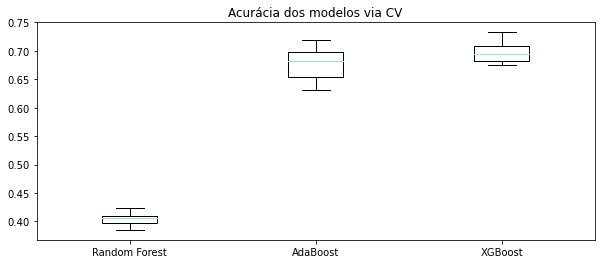

acurácia média nos testes:

Random Forest    0.403964
AdaBoost         0.677461
XGBoost          0.698334
dtype: float64


In [59]:
fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(accuracy_values_AA)
ax.set_xticklabels(cv_result_AA.keys())
ax.set_title('Acurácia dos modelos via CV')
plt.show()

meanAccuracy = pd.DataFrame\
            (list(zip(accuracy_values_AA[0],accuracy_values_AA[1],accuracy_values_AA[2])),\
            columns = ['Random Forest','AdaBoost','XGBoost'])
print(f'acurácia média nos testes:\n\n{meanAccuracy.mean()}')

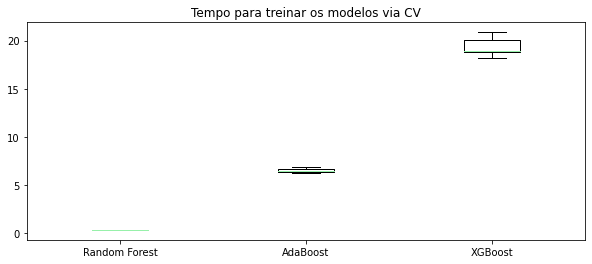

tempo médio de treino:

Random Forest     0.310022
AdaBoost          6.469383
XGBoost          19.365944
dtype: float64


In [60]:
fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(fit_time_values_AA)
ax.set_xticklabels(cv_result_AA.keys())
ax.set_title('Tempo para treinar os modelos via CV')
plt.show()
meanTimeTrain = pd.DataFrame\
            (list(zip(fit_time_values_AA[0],fit_time_values_AA[1],fit_time_values_AA[2])),\
            columns = ['Random Forest','AdaBoost','XGBoost'])
print(f'tempo médio de treino:\n\n{meanTimeTrain.mean()}')

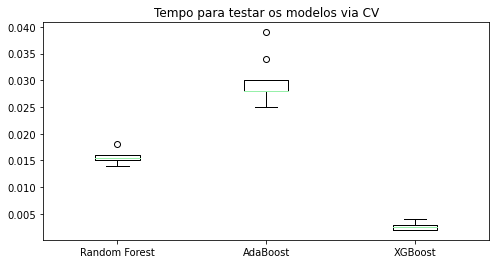

tempo médio de teste:

Random Forest    0.015501
AdaBoost         0.029602
XGBoost          0.002600
dtype: float64


In [61]:
fig, ax = plt.subplots(figsize=(8,4))
ax.boxplot(score_time_values_AA)
ax.set_xticklabels(cv_result_AA.keys())
ax.set_title('Tempo para testar os modelos via CV')
plt.show()

meanTimeTest = pd.DataFrame\
            (list(zip(score_time_values_AA[0],score_time_values_AA[1],score_time_values_AA[2])),\
            columns = ['Random Forest','AdaBoost','XGBoost'])
print(f'tempo médio de teste:\n\n{meanTimeTest.mean()}')

In [62]:
# Resultado do modelos -- acurácia no cross validation
actual = 0
print(f'{"model":<32} | {"accuracy":<15}\n{"-"*43}')
for cls in cv_result_AA:
  accuracy = cv_result_AA[cls]["test_score"].mean()
  print(f'{cls:<32} | {accuracy:<1.5f}')
  if (actual < accuracy) :
    cv_result_AA_best_estimator = cv_result_AA[cls]['estimator'][0]

model                            | accuracy       
-------------------------------------------
Random Forest                    | 0.40396
AdaBoost                         | 0.67746
XGBoost                          | 0.69833


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, clf in enumerate(cv_result_AA):
  axs[i].set_title(clf)
  cv_model = cv_result_AA[clf]['estimator'][0]
  plot_confusion_matrix(cv_model, X_test, y_test, normalize='true', ax=axs[i])

plt.show() 